In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import time

In [2]:
train_dataset = torchvision.datasets.FashionMNIST(
    '.',
    train=True,
    transform = transforms.ToTensor(),
    download = True
)
test_dataset = torchvision.datasets.FashionMNIST(
    '.',
    train=False,
    transform = transforms.ToTensor(),
    download = True
)
# number of classes
K = len(set(train_dataset.targets.numpy()))
print("We have %s classes for this problem" % K)

We have 10 classes for this problem


In [3]:
# define the model
class CNN(nn.Module):
  def __init__(self, K):
    super(CNN, self).__init__()
    # conv layers
    self.conv_layers = nn.Sequential(
      # 28x28x1 -> 13x13x32
      nn.Conv2d(in_channels = 1, out_channels = 32, kernel_size = 3, stride = 2),
      nn.ReLU(),
      # 13x13 -> 6x6x64
      nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3, stride = 2),
      nn.ReLU(),
      # 6x6 -> 2x2x128 (HxWxC) where C is the feature maps.
      nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = 3, stride = 2,),
      nn.ReLU()
    )
    # dense layers
    self.dense_layers = nn.Sequential(
      nn.Dropout(.2), # drop 20% of the nodes randomly
      nn.Linear(128 * 2 * 2, 512), # calculate output of conv layers and set as input
      nn.ReLU(),
      nn.Dropout(.2),
      nn.Linear(512, K)   
    )
  
  def forward(self, x):
    out = self.conv_layers(x)
    out = out.view(out.size(0), -1)
    out = self.dense_layers(out)
    return out


In [4]:
# initalize the model
cnn_model = CNN(K)

In [5]:
# pick a device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('selected %s ' % device)
# pass the model to selected device
cnn_model.to(device)

selected cuda:0 


CNN(
  (conv_layers): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2))
    (5): ReLU()
  )
  (dense_layers): Sequential(
    (0): Dropout(p=0.2, inplace=False)
    (1): Linear(in_features=512, out_features=512, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)

In [6]:
# define the loss and optimizers
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn_model.parameters())

In [7]:
# create data loaders for given train and test sets
batch_size = 128

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size = batch_size, 
    shuffle = True
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size = batch_size,
    shuffle = False
)

In [8]:
# define prediction and training functions
def batch_gd(model, criterion, optimizer, train_loader, test_loader, epochs):
  """
  Apply batch gradient descent to given model and data.
  Data must be DataLoader object
  """
  
  train_losses = np.zeros(epochs)
  test_losses = np.zeros(epochs)

  for i in range(epochs):
    t0 = time.time()
    train_loss = []
    test_loss = []
    for inputs, targets in train_loader:
      inputs, targets = inputs.to(device), targets.to(device)
      # we don't need to flatten the input since
      # we use CNN's as first layers of our NN

      # forward pass
      outputs = model(inputs)
      loss = criterion(outputs, targets)
      # backward propagation
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
      # keep the loss
      train_loss.append(loss.item())

    # calculate the loss for training too
    for inputs, targets in test_loader:
      inputs, targets = inputs.to(device), targets.to(device)
      outputs = model(inputs)
      loss = criterion(outputs, targets)
      test_loss.append(loss.item())
    
    # get the average loss for both train and test sets and keep them too
    avg_train_loss = np.mean(train_loss)
    avg_test_loss = np.mean(test_loss)
    train_losses[i] = avg_train_loss
    test_losses[i] = avg_test_loss

    # calculate the time
    t1 = time.time()

    print("-"*50)
    print(f"Epoch {i+1}/{epochs} took {t1-t0:.3f}s \n avg_loss for train: {avg_train_loss:.4f} \n avg_loss for test: {avg_test_loss:.4f}")
    print("-"*50)

  return train_loss, test_loss

def validation_predict(model, data_loader, acc=True):
  """
  Make predictions with given DataLoader object. 
  Return the predictions and accuracy(if acc=True) 
  """
  n_correct = 0
  n_total = 0
  predictions = np.array([])
  with torch.no_grad():
    for inputs, targets in data_loader:
      # we're getting logits from model, so applying
      # softmax would be enough

      # pass the data to gpu
      inputs, targets = inputs.to(device), targets.to(device)
      outputs = model(inputs)

      # return the index that has maximum value of a column
      # this is almost same as applying softmax itself in our situation
      _, preds = torch.max(outputs, 1)
      if acc:
        accuracy = (preds == targets).sum().item()
        n_correct += accuracy
        n_total += (targets.shape[0])
      predictions = np.concatenate((predictions, preds.cpu().numpy()))

  return [predictions,(n_correct/n_total)] if acc else predictions

In [9]:
n_epochs = 15
train_loss, test_loss = batch_gd(cnn_model, criterion, optimizer, train_loader, test_loader, n_epochs)

--------------------------------------------------
Epoch 1/15 took 11.408s 
 avg_loss for train: 0.6472 
 avg_loss for test: 0.4978
--------------------------------------------------
--------------------------------------------------
Epoch 2/15 took 11.210s 
 avg_loss for train: 0.4289 
 avg_loss for test: 0.4121
--------------------------------------------------
--------------------------------------------------
Epoch 3/15 took 11.421s 
 avg_loss for train: 0.3745 
 avg_loss for test: 0.4011
--------------------------------------------------
--------------------------------------------------
Epoch 4/15 took 11.451s 
 avg_loss for train: 0.3382 
 avg_loss for test: 0.3572
--------------------------------------------------
--------------------------------------------------
Epoch 5/15 took 11.419s 
 avg_loss for train: 0.3109 
 avg_loss for test: 0.3396
--------------------------------------------------
--------------------------------------------------
Epoch 6/15 took 11.700s 
 avg_loss

In [10]:
# calculate the accuracy for train and test sets
_, train_accuracy = validation_predict(cnn_model, train_loader)
test_preds, test_accuracy = validation_predict(cnn_model, test_loader)
print(f"Train accuracy: {train_accuracy:.4f} | Test accuracy: {test_accuracy:.4f} ")

Train accuracy: 0.9410 | Test accuracy: 0.8938 


In [11]:
# now plot the losses again with plotly
import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Scatter(x=list(range(1,n_epochs+1)), y=train_loss, name='Train loss', mode = 'lines+markers'))
fig.add_trace(go.Scatter(x=list(range(1,n_epochs+1)), y=test_loss, name='Test loss', mode = 'lines+markers'))
fig.show()

In [12]:
# label mapping to see misclassified predictions
labels = '''T-shirt/top
Trouser
Pullover
Dress
Coat
Sandal
Shirt
Sneaker
Bag
Ankle boot
'''.split("\n")

In [13]:
test_preds = test_preds.astype(np.uint8)
test_inputs = test_dataset.data.numpy()
test_targets = test_dataset.targets.numpy()
misclassified_idx = np.where(test_preds != test_targets)[0]
print(f"Total misclassified image count is {len(misclassified_idx)}")
print(f"{(len(misclassified_idx)/test_targets.shape[0]) * 100:.2f}% of the images are misclassified by the model.")

Total misclassified image count is 1062
10.62% of the images are misclassified by the model.


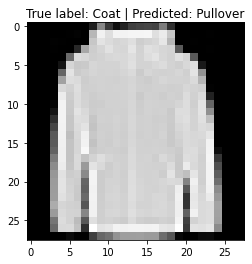

In [14]:
# plot a random example
r = np.random.choice(misclassified_idx)
plt.imshow(test_inputs[r].reshape(28,28), cmap = 'gray')
plt.title(f"True label: {labels[test_targets[r]]} | Predicted: {labels[test_preds[r]]}")
plt.show()